In [219]:
# default_exp data_augmentation
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Augmenting OCR and VectorLearner Data

> Add noise and other effects to make the OCR model more robust. The augmentation should be differentiably applicable to outputs from `VectorLearner` as well.

In [220]:
#export
from aifont.core import *
from aifont.fontlearner import *
from aifont.ocrlearner import *
from collections import OrderedDict
from enum import Enum, auto
from fastai.data.all import *
from fastai.vision.all import *
import gc
from itertools import product
from nbdev.showdoc import *
from pandas import DataFrame
import pydiffvg
import torch
import torchvision.transforms.functional as VF
import torchvision.transforms as VT
from typing import Callable, List, Protocol, Tuple, Union

## Utilities

In [221]:
#export

def create_font_learner(
    ocr_model = None, 
    ocr_learner = None, 
    vocab = VOCAB_UC,
    letters = None,
    folder = None, 
    normalise = False, 
    epoch_len = 1,
    vector_class = SansSerifFontRL, 
    input_shape = None, 
    n_colors_out = 1, 
    eps = None, 
    lr = 1e-2, 
    debug = False, 
    cbs = None, 
    seed = None, 
    init_range = 2.,
    samples = None,
    bs = None,
    ) -> VectorLearner:
    """A factory function for creating a `VectorLearner` for full font optimisation."""

    if eps is not None: warn(f"Using eps {eps}")
    if ocr_model is not None and input_shape is None:
        input_shape = (28,28)
        warn(f"Using default input_shape: {input_shape}")
    
    if ocr_model is None: ocr_model = ocr_learner.model
    if vocab is None: vocab = get_vocab(ocr_learner)

    raster_norm = ocr_learner.dls.train.after_batch[1] if normalise else None

    if input_shape is None:
        ocr_img = ocr_learner.dls.train_ds[0][0]
        canvas_width = ocr_img.width
        canvas_height = ocr_img.height
    else: canvas_width, canvas_height = input_shape

    def get_dl(): return LetterDL.from_vocab(vocab, epoch_len=epoch_len, bs=bs) if letters is None else \
                         LetterDL(vocab=vocab, letters=letters, epoch_len=epoch_len, bs=bs)
    dls = DataLoaders(get_dl(), get_dl())

    image_saver = ImageSaver(folder=folder) if folder is not None else None
    render_layer = vector_class(vocab=vocab,
                                raster_norm=raster_norm, 
                                rendered_callback=image_saver,
                                canvas_width=canvas_width, 
                                canvas_height=canvas_height,
                                n_colors_out=n_colors_out,
                                seed=seed,
                                eps=eps,
                                init_range=init_range,
                                samples=samples)
    if debug: render_layer.debug = debug
    font_model = render_layer

    # Params will be added by Learner
    get_optim = partial(Adam, lr=lr,
                              mom=.5,
                              sqr_mom=.9,
                              wd=0.) # NB. Eps can be also modified

    loss = OCRAndParamLoss(ocr_model=ocr_model,
                           vector_model=render_layer,
                           debug=debug)

    vector_learner = VectorLearner(dls=dls,
                                   model=font_model,
                                   loss_func=loss,
                                   opt_func=get_optim,
                                   cbs=cbs,
                                   image_saver=image_saver)

    return vector_learner

def get_learner(seed=42, **kwargs):
    gc.collect()
    if 'ocr_model' not in locals() or ocr_model is None:
        ocr_model = load_ocr_model(arch=kaggle_cnn_a_with_res, 
                                   df=get_combined_az_and_tmnist_df)
    cb = DebugCB(vocal=False)
    learner = create_font_learner(letters=None,
                                cbs=cb,
                                folder=None,
                                ocr_model=ocr_model,
                                n_colors_out=1,
                                lr=1e-2, 
                                init_range=2.,
                                seed=seed,
                                **kwargs)
    return learner

## 1. Augmentations

In [222]:
DUMP_FOLDER = "results/test_9_whole_alphabet"
VARS_WO_DIV_ADAM_PATH = os.path.join(DUMP_FOLDER, "selected_variations_wo_div_adam.pkl")
sel_vars_df = load(VARS_WO_DIV_ADAM_PATH)
learner = get_learner()
v = sel_vars_df.iloc[0]
learner.load_param_dict(v.final_params)
img_a = learner.render_letter("A")
display(img_a)

/var/folders/3p/10hbv0415234v3x5ctp50l4m0000gn/T/ipykernel_10614/900511316.py:28: UserWarning: Using default input_shape: (28, 28)
  warn(f"Using default input_shape: {input_shape}")


In [223]:
img_t = learner.render_letter("A", as_image=False)
methods = "mix add sub".split()

def add_noise(
    t: Tensor,
    method = "mix",
    f = .5,
    as_image = False
    ) -> Tensor:
    """Add random noise to the tensor."""
    noise = torch.rand_like(img_t)
    if   method == "mix": img_t_aug = (1 - f) * img_t + f * noise
    elif method == "add": img_t_aug = torch.clip(img_t + f * noise, max=1)
    elif method == "sub": img_t_aug = torch.clip(img_t - f * noise, min=0)
    return img_from_tensor(img_t_aug) if as_image else img_t_aug

for method in methods: 
    display(add_noise(img_t, method=method, as_image=True))

With GaussianBlur, we can easily simulate motion blur as well. The kernel_size parameter defines the x and y distortion.

In [224]:
blurrer = VT.GaussianBlur(kernel_size=(3, 3), sigma=(0.1, 5))
for img in [blurrer(img_a) for _ in range(4)]: display(img)

In [225]:
perspective_transformer = VT.RandomPerspective(distortion_scale=0.6, p=1.0, fill=255)
for img in [perspective_transformer(img_a) for _ in range(4)]: display(img)

## 2. Test the Transforms With the OCR Model

In [226]:
if 'ocr_data' not in locals() or ocr_data is None:
    ocr_data = get_combined_az_and_tmnist_df()
ocr_data.head()

,0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,...,0.639,0.640,0.641,0.642,0.643,0.644,0.645,0.646,0.647,0.648
181716,14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
147107,14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
141450,14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
188409,14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
157835,14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


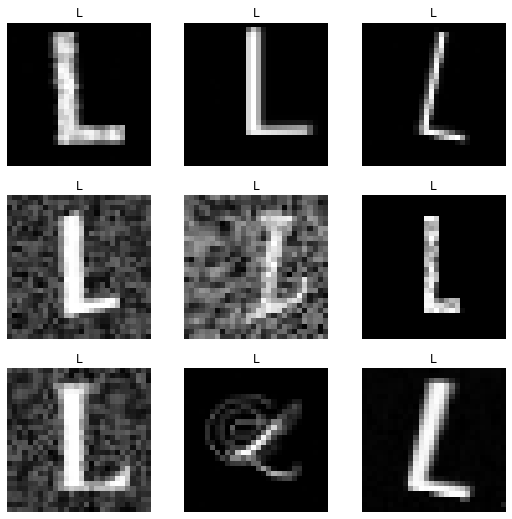

In [245]:
def is_image(x: Tensor): return x.ndim > 2
def is_pil(img): return isinstance(img, Image.Image)

ImageTypes = (PILImage, PILImageBW, Image.Image)
TensorOrImage = (Tensor, *ImageTypes)

class BlendingMethod(Enum):
    MIX = auto()
    ADD = auto()
    SUB = auto()
BLENDING_METHODS = [o for o in BlendingMethod]

IMG = None

def add_noise(x: TensorOrImage,
    method: BlendingMethod = None,
    f: Union[float, Tensor, tuple, list] = None, # Fixed value, range as tuple or None for (0., 1.)
    clip = (0., 1.)
    ) -> Tensor:
    """Add random noise to the tensor."""
    if method is None: method = random.choice(BLENDING_METHODS)
    if f is None:     fac = random.random()
    elif is_listy(f): fac = f[0] + random.random() * (f[1] - f[0])
    else:             fac = f
    noise = torch.rand(x.shape)
    xt = VF.to_tensor(x) if is_pil(x) else x
    assert xt.max() <= 1. + EPS, "Use image tensors in range (0, 1) for add_noise"
    if   method == BlendingMethod.MIX: xt = (1. - fac) * xt + fac * noise
    elif method == BlendingMethod.ADD: xt = xt + fac * noise
    elif method == BlendingMethod.SUB: xt = xt - fac * noise
    else: raise NotImplementedError(f"Unsupported BlendingMethod {method}")
    if clip is not None: xt = torch.clip(xt, *clip)
    return VF.to_pil_image(xt) if is_pil(x) else xt

class RandImgTransform(RandTransform):
    """Perform one of `self.tfms` on an image or tensor with propability `p`."""
    def __init__(self, 
        p = 0.5, 
        tfms = [noop],
        **kwargs
        ):
        super().__init__(p=p, **kwargs)
        store_attr()
    def _encodes(self, x): return self.tfms[0](x) if len(self.tfms) == 1 else random.choice(self.tfms)(x)
    def encodes(self, x: Tensor):     return self._encodes(x) if is_image(x) else x
    def encodes(self, x: ImageTypes): return self._encodes(x)
    def encodes(self, x): raise ValueError(f"RandImgTransform cannot be applied to {type(x)}")

class GaussianBlur(RandImgTransform):
    """Gaussian blur with propability `p`, kernel `kernel_size` or `random_size`, and `sigma`."""
    def __init__(self, 
        p = 0.5, 
        kernel_size = (3, 3), 
        random_size: int = None,
        sigma = (0.1, 5), 
        **kwargs
        ):
        if random_size is not None:
            assert random_size % 2 == 1
            kernel_size = product(range(1, random_size + 2, 2), repeat=2)
        else: kernel_size = [kernel_size]
        tfms = [VT.GaussianBlur(kernel_size=o, sigma=sigma) for o in kernel_size if o != (1,1)]
        super().__init__(p=p, tfms=tfms, **kwargs)
        store_attr()

class Noise(RandImgTransform):
    """Add noise with propability `p`, factor `f` and blending `method`. Leave to `None` to randomise."""
    def __init__(self, 
        p = 0.5, 
        f = None,
        method: BlendingMethod = None,
        clip = (0., 1.),
        **kwargs
        ):
        clip = [float(o) for o in clip]
        tfms = [partial(add_noise, method=method, f=f, clip=clip)]
        super().__init__(p=p, tfms=tfms, **kwargs)
        store_attr()

size = 28
vocab = VOCAB_UC
bs = len(vocab)
ocr_data_subset = ocr_data.iloc[-500:].copy()

blur = GaussianBlur(p=.5, random_size=5)
noise = Noise(p=.5, f=(0., .6))
item_tfms = [blur, noise]

tfms = aug_transforms(mult=1.0, do_flip=False, flip_vert=False, max_rotate=15.0, 
                      min_zoom=0.85, max_zoom=1.15, max_warp=.25, p_affine=.5, 
                      p_lighting=0., xtra_tfms=None, size=size, mode='bilinear', 
                      pad_mode='reflection', align_corners=True, batch=False, 
                      min_scale=1.0)
del(tfms[1]) # Remove lighting tfm

dls = ImageDataLoadersDF.from_df(ocr_data_subset, vocab=VOCAB_UC,
                                 width=size, height=size,
                                 num_workers=0,   # Needed for Mac
                                 valid_pct=0.2, 
                                 item_tfms=item_tfms,
                                 batch_tfms=tfms, # This raises if used as item_tfms
                                 seed=42, bs=bs)
dls.show_batch()

Let's test the transformations on data generated by the font learner.

In [228]:
sel_vars_df = load(VARS_WO_DIV_ADAM_PATH)
learner = get_learner()
v = sel_vars_df.iloc[0]
learner.load_param_dict(v.final_params)
img_t = learner.render_letter("A", as_image=False)

/Users/kallejarvenpaa/opt/miniconda3/envs/ai-font-p3.9/lib/python3.9/site-packages/fastai/learner.py:55: UserWarning: Could not load the optimizer state.
  if with_opt: warn("Could not load the optimizer state.")
/var/folders/3p/10hbv0415234v3x5ctp50l4m0000gn/T/ipykernel_10614/900511316.py:28: UserWarning: Using default input_shape: (28, 28)
  warn(f"Using default input_shape: {input_shape}")


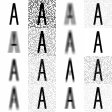

In [238]:
aug_imgs = []
for _ in range(8):
    aug_imgs.append(blur.encodes(img_t))
    aug_imgs.append(noise.encodes(img_t))
image_grid([img_from_tensor(o) for o in aug_imgs])

> These transformation will be added to `ocrlearner` and we'll train an OCR model using them.

## Export

In [ ]:
#hide
from nbdev.export import notebook2script; notebook2script()

Converted 01_fontlearnertests.ipynb.
Converted 02_first_letter_and_optim_tests.ipynb.
Converted 03_vector_models.ipynb.
Converted 04_font_statistics.ipynb.
Converted 05_full_aphabet_optimisation.ipynb.
Converted 06_data_augmentation.ipynb.
Converted aifont_core.ipynb.
Converted aifont_fontlearner.ipynb.
Converted aifont_fontsampler.ipynb.
Converted aifont_ocrlearner.ipynb.
Converted index.ipynb.
